In [22]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import opendatasets as od
from keras.src.metrics.accuracy_metrics import accuracy

In [23]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Skipping, found downloaded files in ".\cats-and-dogs-for-classification" (use force=True to force download)


In [24]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [25]:
train_data_dir = "cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "cats-and-dogs-for-classification/cats_dogs/test"

In [26]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    subset="training",
    validation_split=0.1,
    seed=42
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    subset="validation",
    validation_split=0.1,
    seed=42
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [27]:
class_names = train_data.class_names
print(class_names)

['cats', 'dogs']


In [28]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


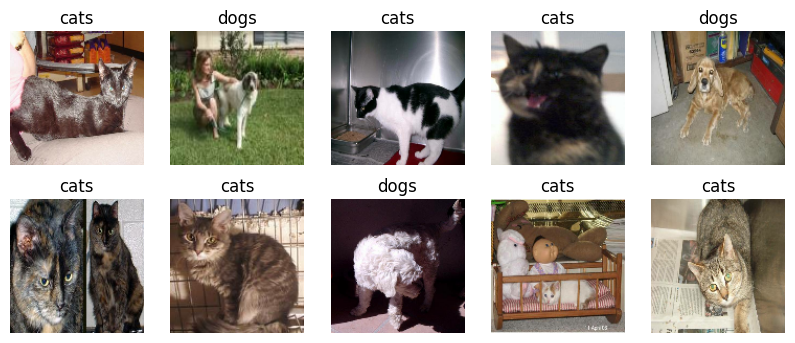

In [29]:
# plot some images
plt.figure(figsize=(10, 4))
for image, label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

## data preprocessing

In [30]:
for image,label in train_data.take(1):
    for i in range(1):
        print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [31]:
# Normalization layer
train_data = train_data.map(lambda x, y: (x / 255.0, y))
validation_data = validation_data.map(lambda x, y: (x / 255.0, y))
test_data = test_data.map(lambda x, y: (x / 255.0, y))

In [32]:
for image,label in train_data.take(1):
    for i in range(1):
        print(image)

tf.Tensor(
[[[[0.15117954 0.08451287 0.12372855]
   [0.1564951  0.08982843 0.12904412]
   [0.14387254 0.07720588 0.11642157]
   ...
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.15078124 0.08411458 0.12333027]
   [0.1463848  0.07971814 0.11893383]
   [0.13852635 0.07185968 0.11107536]
   ...
   [0.         0.         0.        ]
   [0.         0.00127145 0.        ]
   [0.         0.         0.        ]]

  [[0.15681386 0.09014719 0.12936288]
   [0.15010071 0.08343404 0.12264973]
   [0.1491728  0.08250613 0.12172181]
   ...
   [0.00392157 0.         0.        ]
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.7237403  0.6738876  0.726761  ]
   [0.7528033  0.7035823  0.75956535]
   [0.77319306 0.71951526 0.7698836 ]
   ...
   [0.04705882 0.00392157 0.03529412]
   [0.05098039 0.         0.03529412]
   [0.0395804  0.         0.03137255]]

  [[0.7596398  0.66668636 0.694030

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

#### Build the model

In [34]:
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten()) # flatten the 3D feature maps to 1D feature vectors

model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,325,825 (12.69 MB)

 Trainable params: 3,325,569 (12.69 MB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
# Compile the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

In [37]:
start_time = time.time()

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20
)

end_time = time.time()

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.5765 - loss: 0.6868 - val_accuracy: 0.6187 - val_loss: 0.6554
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.5994 - loss: 0.6628 - val_accuracy: 0.6575 - val_loss: 0.6169
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.6376 - loss: 0.6384 - val_accuracy: 0.6025 - val_loss: 0.6586
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.6399 - loss: 0.6299 - val_accuracy: 0.5562 - val_loss: 0.8916
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.6623 - loss: 0.6079 - val_accuracy: 0.5925 - val_loss: 0.7255
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.6651 - loss: 0.6001 - val_accuracy: 0.6888 - val_loss: 0.5905
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 311ms/step - accuracy: 0.6980 - loss: 0.5767 - val_accuracy: 0.6562 - val_loss: 0.5996
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 303ms/step - accuracy: 0.7080 - loss: 0.5628

In [43]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 565.8694875240326 seconds


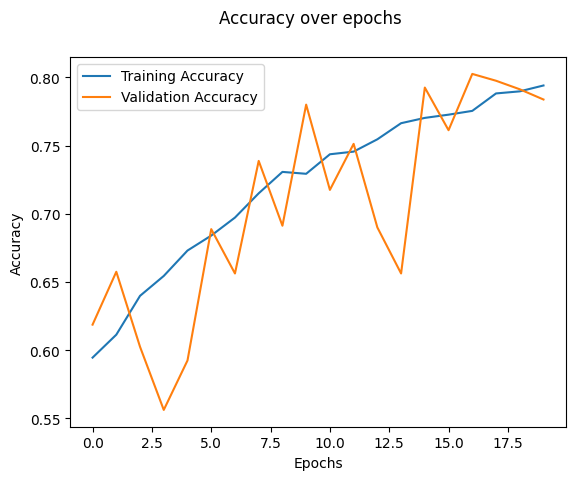

In [39]:
fig = plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
fig.suptitle('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

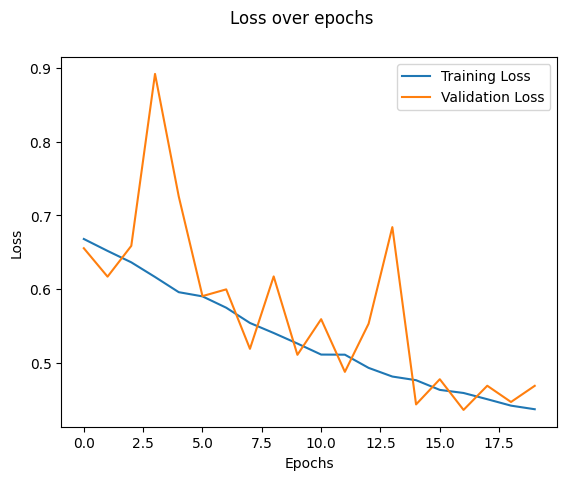

In [40]:
fig = plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
fig.suptitle('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluate the model on test data

In [44]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [45]:
for batch in test_data:
    images, labels = batch
    predictions = model.predict(images)
    precision.update_state(labels, predictions)
    recall.update_state(labels, predictions)
    accuracy.update_state(labels, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [46]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7094542384147644>

In [47]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9229999780654907>

In [48]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7724999785423279>

#### Save the model

In [49]:
import cv2

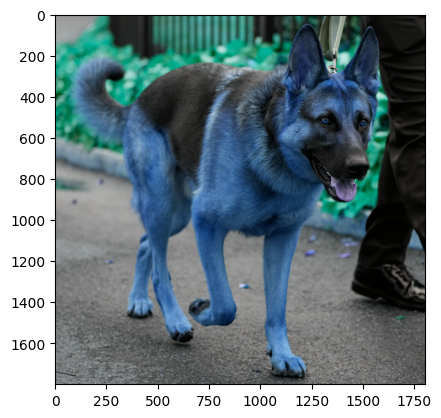

In [50]:
image = cv2.imread('Dog.jpg')
plt.imshow(image)
plt.show()

In [51]:
resized_image = cv2.resize(image, (128, 128))
normalized_image = resized_image / 255.0

In [52]:
normalized_image

array([[[0.59215686, 0.59215686, 0.59215686],
        [0.59607843, 0.59607843, 0.59607843],
        [0.59607843, 0.59607843, 0.59607843],
        ...,
        [0.15294118, 0.14509804, 0.14117647],
        [0.12156863, 0.11372549, 0.10980392],
        [0.0745098 , 0.06666667, 0.0627451 ]],

       [[0.61176471, 0.61176471, 0.61176471],
        [0.61176471, 0.61176471, 0.61176471],
        [0.60784314, 0.60784314, 0.60784314],
        ...,
        [0.15294118, 0.14509804, 0.14117647],
        [0.1372549 , 0.12941176, 0.1254902 ],
        [0.13333333, 0.12156863, 0.12156863]],

       [[0.62745098, 0.62745098, 0.62745098],
        [0.61960784, 0.62745098, 0.62745098],
        [0.61176471, 0.61960784, 0.61960784],
        ...,
        [0.17254902, 0.16470588, 0.16078431],
        [0.18039216, 0.17254902, 0.16862745],
        [0.18823529, 0.18039216, 0.17647059]],

       ...,

       [[0.47843137, 0.49411765, 0.49803922],
        [0.40784314, 0.42352941, 0.42745098],
        [0.45490196, 0

In [53]:
np.expand_dims(normalized_image, 0).shape

(1, 128, 128, 3)

In [54]:
predictions= model.predict(np.expand_dims(normalized_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [55]:
predictions

array([[0.9435496]], dtype=float32)

In [56]:
class_names

['cats', 'dogs']

In [57]:
if predictions >= 0.5:
    print(class_names[1])
else:
    print(class_names[0])

dogs
